## Практикум на ЭВМ. ВМК МГУ
# Задание 2. Метрические алгоритмы классификации

### Выполнил студент 317 группы *Гарипов Тимур*
### Москва, 25.10.15
---

# Краткое описание задания
Данное задание направлено на ознакомление с метрическими алгоритмами классификации, а также методами
работы с текстовой информацией. Выполненное задание прдетсавлено в **IPython notebook**. 

---

В следующей ячейке выполняется подключение необходимых модулей.

In [1]:
import numpy as np
import scipy
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import time
from sklearn.neighbors import NearestNeighbors
import sys
import re
%matplotlib inline

---
# Часть 1. Датасет MNIST

1\. Прежде всего выполняется заргузка датасета. 
В переменную data сохраняются объекты, в переменную target &mdash; классы объектов.

In [2]:
mnist = sklearn.datasets.fetch_mldata("MNIST original")
data = mnist['data']
target = mnist['target']

---
2\. Затем выборка разбивается на тренировочную (первые 60000 объектов) и тестовую (оставшиеся 10000 объектов).

In [3]:
x_train = data[:60000]
x_test = data[60000:]
y_train = target[:60000]
y_test = target[60000:]

---
3\. Для каждого класса визуализируются 5 случайных объектов из этого класса.

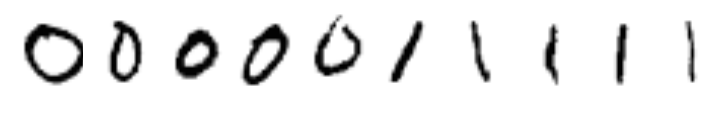

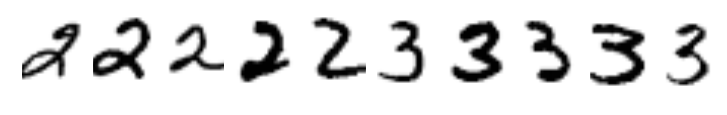

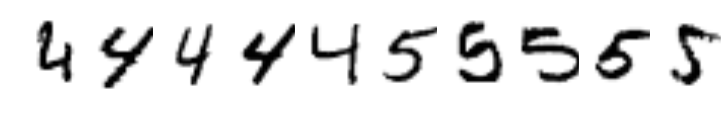

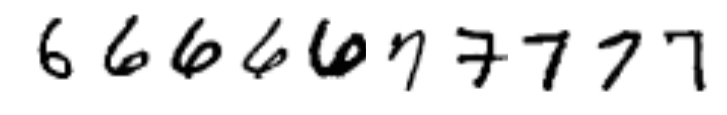

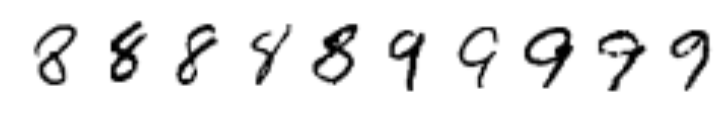

In [4]:
for group in range(0, 10, 2):
    fig, axes = plt.subplots(1, 10, sharey=True, sharex=False, figsize=(12.5,1.5))
    for label in range(2):
        ind = np.where(target == group + label)[0]
        np.random.seed(634624)
        np.random.shuffle(ind)
        for j in range(5):
            axes[label * 5 + j].axis('off')        
            axes[label * 5 + j].imshow(np.reshape(data[ind[j]], (28, 28)), cmap='Greys')
plt.show()

---
4\.
В следующей ячейки описаны функции:

* kneighbors_by_parts. Принимает на вход алгоритм для нахождения ближайших соседей, тестовую выборку и число N. Разбивает тестовую выборку на группы по N объектов, для каждой группы производит поиск ближайших соседей и объединяет полученные результаты <br/> <br/>

* calc_distances. Принимает на вход две матрицы, содержащие координаты объектов и возвращает матрицу попарных расстояний между объектами. Расстояние между векторами $x$ и $y$ вычисляется с помощью соотношения:
$$ ||x - y|| = (x - y, x - y) = (x, x) - 2(x, y) + (y, y)$$ <br/> <br/>

* custom_kneighbors. Собственная реализация поиска ближайших соседей, использующая функцию calc_distances <br/> <br/>

* Функции run_nncustom, run_nnbrute, run_nnkdtree, run_nnballtree выполняют запуск и замер времени работы соответсвующего алгоритма поиска ближайших соседей. <br/> <br/>

In [3]:
def kneighbors_by_parts(neighb, test, N = 1000):
    for i in range(0, test.shape[0], N):
        j = min(i + N, test.shape[0])
        (cdist, cind) = neighb(test[i:j])
        if i == 0:
            dist, ind = cdist, cind
        else:
            dist = np.vstack((dist, cdist))
            ind = np.vstack((ind, cind))        
    return (dist, ind)

def calc_distances(X, Y):
    X = X.astype('float64')
    Y = Y.astype('float64')
    return np.sqrt(np.sum(X ** 2, axis=1)[:, np.newaxis] -
                   2.0 * np.dot(X, Y.T) +
                   np.sum(Y ** 2, axis=1)[np.newaxis, :])


def custom_kneighbors(train, test, k=5):
    dist = calc_distances(test, train)
    ind = np.argpartition(dist, k - 1)[:, 0:k]
    dist = np.partition(dist, k - 1)[:, 0:k]    
    return (dist, ind)

def run_nncustom(train, test):
    print("-" * 80)
    print("Custom")
    print("Fit:\n" + "---")
    print("Get neighbors:")
    %time kneighbors_by_parts(lambda y: custom_kneighbors(train, y), test)
    
def run_nnbrute(train, test):
    print("-" * 80)
    print("Brute")
    nn_brute = NearestNeighbors(n_neighbors=5, algorithm='brute')
    print("Fit:")
    %time nn_brute.fit(train)
    print("Get neighbors:")
    %time kneighbors_by_parts(nn_brute.kneighbors, test)    

def run_nnkdtree(train, test):
    print("-" * 80)
    print("kd_tree")
    nn_kdtree = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
    print("Fit:")
    %time nn_kdtree.fit(train)
    print("Get neighbors:")
    %time res = nn_kdtree.kneighbors(test)

def run_nnballtree(train, test):
    print("-" * 80)
    print("ball_tree")
    nn_balltree = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
    print("Fit:")
    %time nn_balltree.fit(train)
    print("Get neighbors:")
    %time res = nn_balltree.kneighbors(test)    


Выше описанные функции используются для того, чтобы исследовать каким точным алгоритмом поиска ближайших соседей следует пользоваться в различных ситуациях. Исследуется зависимоть времени работы алгоритмов от размерности пространтсва признаков. 

Выполняется поиск 5 ближайших соседей. Метрика евклидова. Число признаков: 10, 20, 100. Подмножество
признаков выбирается один раз, случайно. 

Алгоритмы поиска ближайших соседей:

* Собственная реализация на основе функции calc_distances &mdash; "custom"
* sklearn.neighbors.NearestNeighbors(algorithm=’brute’) &mdash; "brute"
* sklearn.neighbors.NearestNeighbors(algorithm=’kd_tree’) &mdash; "kd_tree"
* sklearn.neighbors.NearestNeighbors(algorithm=’ball_tree’) &mdash; "ball_tree"

In [9]:
for num_features in [10, 20, 100]:
    print("****", num_features, " features")
    features_ind = np.arange(data.shape[1])
    np.random.shuffle(features_ind)
    features_ind = features_ind[:num_features]
    train = x_train[:, features_ind]
    test = x_test[:, features_ind]


    run_nncustom(train, test)
    run_nnbrute(train, test)
    run_nnkdtree(train, test)
    run_nnballtree(train, test)


    # Проверка корректности собственной реализации алгоритма k-ближайших соседей
    res = []
    res.append(kneighbors_by_parts(lambda y: custom_kneighbors(train, y), test))
    nn_brute = NearestNeighbors(n_neighbors=5, algorithm='brute')
    nn_brute.fit(train)
    res.append(kneighbors_by_parts(nn_brute.kneighbors, test))
    
    np.testing.assert_almost_equal(np.sort(res[0][0]), np.sort(res[1][0]))
    for i in range(test.shape[0]):
        objs_0 = train[res[0][1][i], :]    
        dist_0 = np.array([])    
        for j in range(objs_0.shape[0]):
            dist_0 = np.append(dist_0, np.sum((objs_0[j] * 1.0 - test[i]) ** 2) ** 0.5)        
        np.testing.assert_almost_equal(res[0][0][i], dist_0)
    print('\n')

**** 10  features
--------------------------------------------------------------------------------
Custom
Fit:
---
Get neighbors:
CPU times: user 36.9 s, sys: 7.64 s, total: 44.5 s
Wall time: 52.7 s
--------------------------------------------------------------------------------
Brute
Fit:
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.61 ms
Get neighbors:
CPU times: user 21.5 s, sys: 1.5 s, total: 23 s
Wall time: 23.2 s
--------------------------------------------------------------------------------
kd_tree
Fit:
CPU times: user 15.9 s, sys: 44 ms, total: 15.9 s
Wall time: 16 s
Get neighbors:
CPU times: user 4.4 s, sys: 8 ms, total: 4.41 s
Wall time: 4.39 s
--------------------------------------------------------------------------------
ball_tree
Fit:
CPU times: user 15.8 s, sys: 56 ms, total: 15.9 s
Wall time: 15.9 s
Get neighbors:
CPU times: user 8.75 s, sys: 28 ms, total: 8.78 s
Wall time: 8.73 s


**** 20  features
--------------------------------------------------------

Алгоритм|Количество признаков|Время поиска ближайших соседей (сек.)
:-|:-:|:-:
custom|10|44
brute|10|23
kd_tree|10|**4**
ball_tree|10|9
||
custom|20|43
brute|20|25
kd_tree|20|**10**
ball_tree|20|41
||
custom|100|63
brute|100|**45**
kd_tree|100|171
ball_tree|100|210


Проведенный эксперимент показывает, что в случаях большого количества признаков выгодно использовать алгоритм "brute". Сосбственная реализация поиска ближайших соседей работает немного дольше, но все же весьма эффективна.

Согласно [описанию](http://scikit-learn.org/stable/modules/neighbors.html) алгоритмов "kd_tree" и "ball_tree", эти алгоритмы пытаются за счет структурирования данных сократить количество операций вычисления расстояния между объектами.  Алгоритм "kd_tree", рекомендуется использовать при небольших размерностях признакового пространства, однако при увеличении количества признаков, время его работы может значительно увеличится, что и демонстрируют проведенные замеры времени работы. Алгоритм "ball_tree" предлагается, как альтернатива "kd_tree" для пространств большой размерности, однако в проведенном эксперименте при использовании 100 признаков, "ball_tree" работает медленнее чем "kd_tree", видимо этот эффект является особенностью данного датасета, либо требуется более детальная настройка параметров алгоритма "ball_tree".

Существенную эффективность алгоритма "brute" можно объяснить тем, что для его работы необходимо лишь вычисление расстояний между объектами. В случае неудачного структурирования данных алгоритмы "kd_tree" и "ball_tree" также вынужденны вычислять расстояния до всех объектов обучающей выборки и кроме того тратить время на работу с построенной структурой.


---
5\. Реализована функций cv_ind для генерации индексов обучающей и валидационной выборки для кросс-валидации с N фолдами. 

Функция cv_train_test принимает выборку, количество фолдов и номер фолда, котрый должен использоваться для валидации, и, используя cv_ind, производит соответвующее разделение на обучающую и валидационную выборки.

In [4]:
def cv_ind(L, N, fold_id, seed=13415):
    perm = np.arange(L)
    np.random.seed(seed)
    np.random.shuffle(perm)    
    train_id = np.array([], dtype='int32')
    test_id = np.array([], dtype='int32')
    pos = 0
    M = N
    for i in range(N):
        step = (L + M - 1) // M
        fold = np.arange(pos, pos + step)
        if i == fold_id:                    
            test_id = np.append(test_id, fold)
        else:            
            train_id = np.append(train_id, fold)
        L -= step
        M -= 1           
        pos += step
    return (perm[train_id], perm[test_id])

def cv_train_test(data, target, N, fold_id, seed=13415):
    train_id, test_id = cv_ind(data.shape[0], N, fold_id, seed)
    return (data[train_id], data[test_id], target[train_id], target[test_id])
    
    

---
6 \. Функция predict принимает на вход следующие параметры: 

* y_train, y_test &mdash; классы объектов обучающей и валидационной выборки соответственно;
* dist &mdash; матрицу расстояний  от объектов валидационной выборки до ближайших объектов обучающей выборки;
* neighbors &mdash; марицу, содержащую индексы ближайших объектов обучающей выборки для каждого объекта валидационной выборки;
* C &mdash; количество классов;
* K &mdash; список чисел $k_1, k_2 \dots, k_n$;
* use_weights &mdash; флаг, обозначающий использование взвешенного либо невзвешенного алгоритма $k$-ближайших соседей. Вес для объекта равен: $\frac{1}{distance + 10^{-9}}$.

Резутат работы функции predict &mdash; кортеж, содержащий:

* массив предсказанных классов объектов валидационной выборки для всех значений параметра $k$ из списка K; 
* доля правильно предсказанных классов объектов валидационной выборки для всех значений параметра $k$ из списка K.


In [5]:
def predict(y_train, y_test, dist, neighbors, C, K, use_weights=False):
    maxk = np.max(K)
    
    ind = np.reshape(np.arange(dist.shape[0]), (dist.shape[0], 1))    
    srt = np.argsort(dist, axis=1)
    neighbors = neighbors[ind, srt]
    dist = dist[ind, srt]
    
    labels = y_train[neighbors].astype('int32')    
    votes = np.zeros((y_test.shape[0], C))    
    if use_weights:
        weights = 1.0 / (dist + 1e-9)
    else:
        weights = np.ones(dist.shape)
    prediction = np.zeros((maxk, y_test.shape[0]))
    for i in range(maxk):        
        votes[np.arange(y_test.shape[0]), labels[:, i]] += weights[:, i]
        prediction[i] = np.argmax(votes, axis=1) 
    prediction = prediction[K - 1]
    return prediction, np.sum(prediction == y_test[np.newaxis, :], axis=1) / y_test.shape[0]

Функция сalc_precision принимает на вход следующие параметры: 

* x_train, y_train &mdash; обучающую выборку (объекты и их классы соответственно);
* x_test, y_test &mdash; валидационную выборку (объекты и их классы соответственно);
* C &mdash; количество классов;
* K &mdash; список чисел $k_1, k_2 \dots, k_n$;
* mertic &mdash; строку, содержащую название метрики, используемой алгоритмом $k$-ближайших соседей;
* use_weights &mdash; флаг, обозначающий использование взвешенного либо невзвешенного алгоритма $k$-ближайших соседей. Вес для объекта равен: $\frac{1}{distance + 10^{-9}}$.


Резутат работы функции calc_precision &mdash; доля правильно предсказанных классов объектов валидационной выборки для всех значений параметра $k$ из списка K.

Для поиска ближайших соседей используется алгоритм sklearn.neighbors.NearestNeighbors(algorithm=’brute’).


In [6]:
def calc_precision(x_train, y_train, x_test, y_test, C, K, metric='euclidean', use_weights=False):    

    nn = sklearn.neighbors.NearestNeighbors(n_neighbors=np.max(K), algorithm='brute', metric=metric)
    nn.fit(x_train)    
    dist, neighbors = kneighbors_by_parts(nn.kneighbors, x_test, 2500)            
    
    _, res = predict(y_train, y_test, dist, neighbors, C, K, use_weights)    
    
    return res

---
7 - 8\. Следующий скрипт выполняет оценку по кросс-валидации с 3 фолдами точности (долю правильно предсказанных ответов) и скорость метода $k$-ближайших соседей в зависимости от следующих факторов:

1. k от 1 до 10 (только влияние на точность).
2. Используется евклидова или косинусная метрика.
3. Используется взвешенный или невзвешенный метод.

In [16]:
N = 3
K = np.arange(1, 11)

for use_w in [False, True]:    
    for metr in ['euclidean', 'cosine']:
        print('Weights: ', use_w)
        print('Metric =', metr)
        print('Fold ', end = '')        
        sys.stdout.flush()
        res = np.zeros(K.size)
        t = 0.0
        for i in range(N):
            cv_x_train, cv_x_test, cv_y_train, cv_y_test = cv_train_test(data, target, N, i)
            
            t1 = time.clock()
            res += calc_precision(cv_x_train, cv_y_train, cv_x_test, cv_y_test, 10, K, metr, use_w)
            t += time.clock() - t1    
            print(i, end=' ')
            sys.stdout.flush()
        print()
        res /= N
        print('Precision:')
        print(res)
        print('Best:', np.max(res), '[ k =', np.argmax(res) + 1, ']')
        print('Time:')
        print('{:.4f} s'.format(t / N))
        print('\n')
        sys.stdout.flush()

Weights:  False
Metric = euclidean
Fold 0 1 2 
Precision:
[ 0.9708      0.96408572  0.97087142  0.96878572  0.96925715  0.96822857
  0.96794286  0.9673      0.9668      0.96620001]
Best: 0.970871424478 [ k = 3 ]
Time:
384.0020 s


Weights:  False
Metric = cosine
Fold 0 1 2 
Precision:
[ 0.97444286  0.97022859  0.97494285  0.97450001  0.97441429  0.97394286
  0.97292857  0.97262857  0.97155714  0.97132858]
Best: 0.974942848153 [ k = 3 ]
Time:
385.4768 s


Weights:  True
Metric = euclidean
Fold 0 1 2 
Precision:
[ 0.9708      0.9708      0.9721      0.97247143  0.97024286  0.97121428
  0.96924286  0.96941429  0.968       0.96850001]
Best: 0.972471431417 [ k = 4 ]
Time:
382.7801 s


Weights:  True
Metric = cosine
Fold 0 1 2 
Precision:
[ 0.97444286  0.97444286  0.97578571  0.97642857  0.9753      0.97574286
  0.97381429  0.97472857  0.97262857  0.97288571]
Best: 0.976428573868 [ k = 4 ]
Time:
387.6469 s




Метрика | Взвешенный метод | Наибольшая точность | Оптимальное количество соседей | Время работы (сек.)
:-:|:-:|:-:|:-:|:-:
евклидова | <span style="color: red"> нет </span> | 0.9708 | 3 | 384
евклидова | <span style="color: green"> да </span> | 0.9724 | 4 | 385
||||
косинусная | <span style="color: red"> нет </span> | 0.9749 | 3 | 382
косинусная | <span style="color: green"> да </span> | **0.9764** | 4 | 387

Полученные результаты свидетельствуют о следующем: 

* использование взвешенного метода позволяет повысить качество классификации;
* методы, использующие косинусную метрику оказываются точнее методов, использующих евклидову метрику;
* увеличние параметра k не позволяет повысить точность;
* разница времен работы разных методов не превосходит 5 секунд при среднем времени работы, равном 384.5 сек.

Лучшим алгоритмом оказывается взвешенный метод 4-ближайших соседей, использующий косинусную метрику.

---
9\. Лучший алгоритм применён к исходной обучающей и тестовой выборке.

In [18]:
nn = NearestNeighbors(n_neighbors=4, algorithm='brute', metric='cosine')
nn.fit(x_train)
dist, neighbors = kneighbors_by_parts(nn.kneighbors, x_test)            
    
prediction, res = predict(y_train, y_test, dist, neighbors, 10, np.array([4]), True)
prediction = prediction[0]
res = res[0]
print(res * y_test.size, '/', y_test.size)
print('Precison:', res)

9752.0 / 10000
Precison: 0.9752


Точность по тестовой($97.5\%$) выборке отличается от точности по кросс-валидации ($97.6\%$) лишь на $0.1\%$. Для данной выборки в [интернете](http://yann.lecun.com/exdb/mnist/) указана наилучшая точность равная $0.9977$, что значительно превосходит результат, полученный выше. Однако для получения таких хороших результатов были использованы алгоритмы, которые значительно сложнее чем метод k-ближайших соседей.

---
10\. Ниже визуализированны несколько объектов из тестовой выборки, на которых были допущены ошибки.

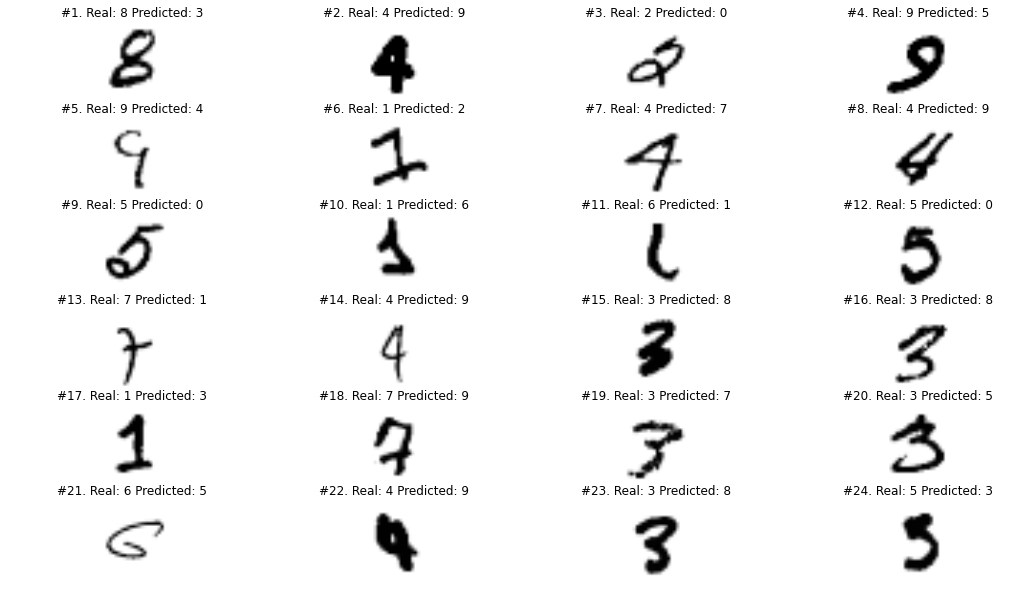

In [39]:
ind = np.where(prediction != y_test)[0]
np.random.seed(1234)
np.random.shuffle(ind)
fig, axes = plt.subplots(6, 4, sharey=True, sharex=False, figsize=(18,10))
for i in range(24):
    ax = i // 4
    ay = i % 4
    axes[ax][ay].axis('off')
    r = str(y_test[ind[i]].astype('int32'))
    p = str(prediction[ind[i]].astype('int32'))
    axes[ax][ay].set_title('#' + str(i + 1) + '. ' + 'Real: ' + r + ' Predicted: ' +  p)
    axes[ax][ay].imshow(np.reshape(x_test[ind[i]], (28, 28)), cmap="Greys")    
plt.show()

Изображенные выше примеры показывают, что имееют место следующие причины неверной классификации:
* цифра написана таким, образом что она имеет некое сходство с какой-нибудь другой цифрой (примеры 5, 6, 13, 19, 22, 24; в примерах 3, 9, 12 округлые цифры были приняты за 0);
* некторые цифры достаточно трудно отличить друг от друга (примеры с цифрами 3 и 8);
* способ написания цифры отличается от того способа написания, который представлен большинством объектов в тренировочной выборке (примеры 2, 7, 14);
* для некоторых объектов даже человеку сложно указать дейтсвительный класс (пример 11).

Для вывода на печать матрицы ошибок реализована функция print_confusion_matrix.

In [29]:
def print_confusion_matrix(mat):
    C = mat.shape[0]
    l = 0
    for i in range(C):
        for j in range(C):
            l = max(l, len(str(mat[i, j])) + 1)
        col_err = np.sum(mat[:, i]) - mat[i][i];
        l = max(l, len(str(col_err)) + 1)
    f = '{:' + str(l) + 'd}'
    print('Predicted:', end='')
    for i in range(C):
        print(f.format(i), end='')
    print(' | Errors')
    print('-' * (l * C + 21))
    for i in range(C):
        print('Real', '{:2d}'.format(i), ' :', end='')
        for j in range(C):
            print(f.format(mat[i, j]), end='')
        print(' | ', np.sum(mat[i]) - mat[i][i])     
    print('-' * (l * C + 21))        
    print('Errors   :', end='')
    for i in range(C):
        print(f.format(np.sum(mat[:, i]) - mat[i][i]), end='')

Ниже происходит вычиление и вывод на печать матрицы ошибок.

In [30]:
mat = sklearn.metrics.confusion_matrix(y_test, prediction)
print_confusion_matrix(mat)   

Predicted:    0    1    2    3    4    5    6    7    8    9 | Errors
-----------------------------------------------------------------------
Real  0  :  977    1    0    0    0    0    1    1    0    0 |  3
Real  1  :    0 1129    3    1    0    0    2    0    0    0 |  6
Real  2  :    8    0 1009    1    1    0    0    8    5    0 |  23
Real  3  :    0    1    3  976    1   12    0    4    9    4 |  34
Real  4  :    2    1    0    0  946    0    6    2    0   25 |  36
Real  5  :    4    0    0    9    1  863    7    1    4    3 |  29
Real  6  :    3    3    0    0    1    3  948    0    0    0 |  10
Real  7  :    2   10    4    0    1    0    0  998    0   13 |  30
Real  8  :    7    1    2    9    3    3    5    4  936    4 |  38
Real  9  :    7    7    2    5    7    3    1    4    3  970 |  39
-----------------------------------------------------------------------
Errors   :   33   24   14   25   15   21   22   24   21   49

* Для всех классов количество случаев верной классификации гораздо больше числа ошибок, связанных с этими классами.

* Наиболее частой ошибкой является предсказание цифры 9, вместо цифры 4. 

* Изображения цифр 0 и 1 оказалось распознать легче, чем изображения остальных цифр.

* Интересным фактом является то, что в разных случаях вместо цифры 8 были предсказаны все возможные цифры, то же самое относится к цифре&nbsp;9. 

---
# Часть 2. Датасет 20 newsgroups.

11\. Загрузка обучающей выборки датасета 20 newsgroups при помощи метода
sklearn.datasets.fetch_20newsgroups. С помощью аргумента remove убраны все заголовки, подписи и цитаты.

In [7]:
trainset = sklearn.datasets.fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

---
12 - 15\. Вычисление признаков для текстовых данных выполняет функция extract_features. 

Для вычисления признаков выполняются следующие шаги:

1. во всех документах все буквы перводятся в нижний регистр;
2. символы, неявляющиеся буквами и цифрами, заменяются на пробелы;
3. каждый документ разбивается на термы по пробельным символам;
4. датасет преобразуется в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j) означает, что в документе i слово j встретилось x раз;
5. производится tf-idf преобразование датасета при помощи sklearn.feature_extraction.text.TfidfTransformer.

Используются дополнительные структуры: 

* term_id &mdash; словарь, который осуществляет нумерацию термов;
* term_list &mdash; список термов.

In [8]:
def extract_features(dataset, term_id, term_list, update_terms=False):
    dataset.initial = dataset.data
    dataset.data = [re.sub('\W+', ' ', x.lower()) for x in dataset.data]
    dataset.terms = [x.split() for x in (text for text in dataset.data)]    
    sparse_data = []
    indices = []
    indptr = [0]
    for doc in dataset.terms:
        for term in doc:
            if update_terms and not(term in term_id):
                term_id[term] = len(term_id)
                term_list.append(term)
            if term in term_id:
                sparse_data.append(1)        
                indices.append(term_id[term])
        indptr.append(len(indices))
    dataset.sparse = scipy.sparse.csr_matrix((sparse_data, indices, indptr),
                                              shape = (len(dataset.data), len(term_id)),
                                              dtype='int32')
    transformer = sklearn.feature_extraction.text.TfidfTransformer()
    dataset.tfidf = transformer.fit_transform(dataset.sparse)

Ниже функция extract_features используется для вычисления признаков для обучающей выборки.

In [15]:
term_id = {}
term_list = []
extract_features(trainset, term_id, term_list, True)

---
16\.
Следующий скрипт производит оценку точности (долю правильно предсказанных ответов) и скорости метода k ближайших соседей при помощи кросс-валидации с 3 фолдами. На одних и тех же фолдах исследуются влияние следующих факторов:

1. k от 1 до 10 (только влияние на точность).
2. Используется евклидова или косинусная метрика.
3. Используется ли преобразование tf-idf.
4. Используется взвешенный или невзвешенный метод k ближайших соседей

Привиденный ниже скрипт использует вспомогательные функции из части 1.

In [54]:
N = 3
K = np.arange(1, 11)

for use_tfidf in [False, True]:
    for use_w in [False, True]:        
        for metr in ['euclidean', 'cosine']:
            print('TF*IDF:', use_tfidf)
            print('Weights: ', use_w)
            print('Metric =', metr)
            sys.stdout.flush()
            res = np.zeros(K.size)
            t = 0.0
            print('Fold ', end='')
            sys.stdout.flush()
            for i in range(N):                                
                if use_tfidf:
                    x = trainset.tfidf
                else:
                    x = trainset.sparse
                cv_x_train, cv_x_test, cv_y_train, cv_y_test = cv_train_test(x, trainset.target, N, i)

                t1 = time.clock()
                res += calc_precision(cv_x_train, cv_y_train, cv_x_test, cv_y_test, 20, K, metr, use_w)
                t += time.clock() - t1    
                print(i, end = ' ')
                sys.stdout.flush()
            print()
            res /= N
            print('Precision:')
            print(res)
            print('Best:', np.max(res), '[ k =', np.argmax(res) + 1, ']')
            print('Time:')
            print('{:.4f} s'.format(t / N))
            print('\n')
            sys.stdout.flush()

TF*IDF: False
Weights:  False
Metric = euclidean
Fold 0 1 2 
Precision:
[ 0.21133147  0.18472674  0.18198677  0.18631783  0.19144402  0.19480301
  0.19524479  0.19639389  0.19789628  0.19984106]
Best: 0.211331472469 [ k = 1 ]
Time:
5.1664 s


TF*IDF: False
Weights:  False
Metric = cosine
Fold 0 1 2 
Precision:
[ 0.28407378  0.27099195  0.26524684  0.25711554  0.25508253  0.25375611
  0.25154673  0.25198931  0.25260767  0.25366849]
Best: 0.28407377974 [ k = 1 ]
Time:
4.8429 s


TF*IDF: False
Weights:  True
Metric = euclidean
Fold 0 1 2 
Precision:
[ 0.21133147  0.21168502  0.21504327  0.21813689  0.21893222  0.21999304
  0.21760685  0.21575063  0.2148665   0.2170763 ]
Best: 0.219993041911 [ k = 6 ]
Time:
5.1190 s


TF*IDF: False
Weights:  True
Metric = cosine
Fold 0 1 2 
Precision:
[ 0.28407378  0.28495765  0.28531127  0.28274832  0.27938919  0.27558797
  0.27390855  0.27116879  0.27063847  0.26807505]
Best: 0.28531127067 [ k = 3 ]
Time:
4.8774 s


TF*IDF: True
Weights:  False
Metric = 


  
Метрика | Ипользование tf-idf | Взвешенный метод | Наибольшая точность | Оптимальное количество соседей | Время работы (сек.)
:-:|:-:|:-:|:-:|:-:|:-:
евклидова | <span style="color: red"> нет </span> | <span style="color: red"> нет </span> | 0.2113 | 1 | 5.1
евклидова | <span style="color: red"> нет </span> | <span style="color: green"> да </span>  | 0.2199 | 6 | 5.1
евклидова | <span style="color: green"> да </span>  | <span style="color: red"> нет </span>| 0.1359 | 1 | 4.7
евклидова | <span style="color: green"> да </span>  | <span style="color: green"> да </span>  | 0.1365 | 2 | 4.7
|||||
косинусная | <span style="color: red"> нет </span> | <span style="color: red"> нет </span> | 0.2840 | 1 | 4.8
косинусная | <span style="color: red"> нет </span> | <span style="color: green"> да </span>  | 0.2853 | 3 | 4.8
косинусная | <span style="color: green"> да </span>  | <span style="color: red"> нет </span>| 0.6159 | 6 | 4.6
косинусная | <span style="color: green"> да </span>  | <span style="color: green"> да </span>  | **0.6399**| 6 | 4.6

Полученные результаты свидетельствуют о следующем: 

* использование взвешенного метода позволяет повысить качество классификации;
* использование tf-idf преобразования позволяет значительно повысить качество классификации при использовании косинусной метрики;
* изменение значений рассмотренных параметров незначительно сказывается на времени работы программы.

Довольно странно, что точность алгоритма, использующего евклидову метрику, падает при произведении tf-idf преобразования. Учитывая то, что tf-idf признаки норимрованны, можно показать, что точность алгоритмов использующих косинусную и евклидову метрику не должна различаться. 

Дейтсвительно, косинусное расстояние между векторами $u$ и $v$ выражается как:
$$
    \rho_{cos}(u, v) = 1 - \frac{(u, v)}{||u|| \, ||v||},
$$

учтивая что $||u|| = ||v|| = 1$, это выражение можно переписать как:

$$
    1 - (u, v).
$$

Теперь запишем выражение для Евклидовой метрики:

$$
    \rho_{e}(u, v) = \sqrt{(u - v, u - v)} = \sqrt{||u|| - 2 (u, v) + ||v||} = \sqrt{2 - 2(u, v)} = \sqrt{2  \rho_{cos}}.
$$

Полученное соотношение показывает связь между косинусным и евклидовым рассотянием. Эта связь позволяет, заключить, что алгоритмы, использующие косинусную и евклидову метрику, будут находить одних и тех же ближайших соседей и получать одни и те же результаты.




Оказывается, что падение точности алгортима с Евклидовой метрикой вызвано тем, что в выборке присутствуют пустые тексты, для которых вектор tf-idf оказывается нулевым. Из-за нормировки tf-idf признаков и большой размерности признакового пространства ближайшими по евклидовой метрике текстами в большинстве случаев оказываются пустые тексты, что понижает точность классификации. 

В следующей ячейке производится запуск аналогичного эксперимента с предварительным удалением пустых текстов из выборки (оказалось, что в выборке имеется порядка 300 пустых текстов).


In [52]:
#extract_features(trainset, term_id, term_list, True
trainset_f = sklearn.datasets.base.Bunch()
trainset_f.data = []
trainset_f.target = []
for ind, doc in enumerate(trainset.data):
    if re.sub('\W+', ' ', doc).strip() != '':
        trainset_f.data.append(doc)        
        trainset_f.target.append(trainset.target[ind])
        
trainset_f.target = np.array(trainset_f.target)
term_id_f = {}
term_list_f = []
extract_features(trainset_f, term_id_f, term_list_f, True)

N = 3
K = np.arange(1, 11)

for use_tfidf in [False, True]:
    for use_w in [False, True]:        
        for metr in ['euclidean', 'cosine']:
            print('TF*IDF:', use_tfidf)
            print('Weights: ', use_w)
            print('Metric =', metr)
            sys.stdout.flush()
            res = np.zeros(K.size)
            t = 0.0
            print('Fold ', end='')
            sys.stdout.flush()
            for i in range(N):                                
                if use_tfidf:
                    x = trainset_f.tfidf
                else:
                    x = trainset_f.sparse
                cv_x_train, cv_x_test, cv_y_train, cv_y_test = cv_train_test(x, trainset_f.target, N, i)

                t1 = time.clock()
                res += calc_precision(cv_x_train, cv_y_train, cv_x_test, cv_y_test, 20, K, metr, use_w)
                t += time.clock() - t1    
                print(i, end = ' ')
                sys.stdout.flush()
            print()
            res /= N
            print('Precision:')
            print(res)
            print('Best:', np.max(res), '[ k =', np.argmax(res) + 1, ']')
            print('Time:')
            print('{:.4f} s'.format(t / N))
            print('\n')
            sys.stdout.flush()

TF*IDF: False
Weights:  False
Metric = euclidean
Fold 0 1 2 
Precision:
[ 0.21646674  0.18747728  0.19002181  0.18902217  0.1938386   0.19501999
  0.19629226  0.19747365  0.19820065  0.19847328]
Best: 0.216466739368 [ k = 1 ]
Time:
5.8878 s


TF*IDF: False
Weights:  False
Metric = cosine
Fold 0 1 2 
Precision:
[ 0.29025809  0.27117412  0.26599418  0.26254089  0.26135951  0.26208651
  0.25926936  0.25899673  0.25981461  0.25817884]
Best: 0.290258087968 [ k = 1 ]
Time:
5.1283 s


TF*IDF: False
Weights:  True
Metric = euclidean
Fold 0 1 2 
Precision:
[ 0.21646674  0.21646674  0.21819338  0.22046529  0.2215558   0.21919302
  0.21901127  0.22055616  0.21910214  0.22182843]
Best: 0.221828426027 [ k = 10 ]
Time:
5.0541 s


TF*IDF: False
Weights:  True
Metric = cosine
Fold 0 1 2 
Precision:
[ 0.29025809  0.29016721  0.29262087  0.2848964   0.28253362  0.27853508
  0.27371865  0.27271901  0.27308252  0.2739004 ]
Best: 0.29262086514 [ k = 3 ]
Time:
5.0282 s


TF*IDF: True
Weights:  False
Metric 

### Результаты до удаления пустых текстов
Метрика | Ипользование tf-idf | Взвешенный метод | Наибольшая точность | Оптимальное количество соседей | Время работы (сек.)
:-:|:-:|:-:|:-:|:-:|:-:
евклидова | <span style="color: red"> нет </span> | <span style="color: red"> нет </span> | 0.2113 | 1 | 5.1
евклидова | <span style="color: red"> нет </span> | <span style="color: green"> да </span>  | 0.2199 | 6 | 5.1
евклидова | <span style="color: green"> да </span>  | <span style="color: red"> нет </span>| 0.1359 | 1 | 4.7
евклидова | <span style="color: green"> да </span>  | <span style="color: green"> да </span>  | 0.1365 | 2 | 4.7
|||||
косинусная | <span style="color: red"> нет </span> | <span style="color: red"> нет </span> | 0.2840 | 1 | 4.8
косинусная | <span style="color: red"> нет </span> | <span style="color: green"> да </span>  | 0.2853 | 3 | 4.8
косинусная | <span style="color: green"> да </span>  | <span style="color: red"> нет </span>| 0.6159 | 6 | 4.6
косинусная | <span style="color: green"> да </span>  | <span style="color: green"> да </span>  | **0.6399**| 6 | 4.6

### Результаты после удаления пустых текстов

Метрика | Ипользование tf-idf | Взвешенный метод | Наибольшая точность | Оптимальное количество соседей | Время работы (сек.)
:-:|:-:|:-:|:-:|:-:|:-:
евклидова | <span style="color: red"> нет </span> | <span style="color: red"> нет </span> | 0.2164 | 1 | 5.9
евклидова | <span style="color: red"> нет </span> | <span style="color: green"> да </span>  | 0.2210 | 10 | 5.1
евклидова | <span style="color: green"> да </span>  | <span style="color: red"> нет </span>| 0.6302 | 8 | 4.9
евклидова | <span style="color: green"> да </span>  | <span style="color: green"> да </span>  | 0.6489 | 5 | 4.9
|||||
косинусная | <span style="color: red"> нет </span> | <span style="color: red"> нет </span> | 0.2903 | 1 | 5.1
косинусная | <span style="color: red"> нет </span> | <span style="color: green"> да </span>  | 0.2926 | 3 | 5.0
косинусная | <span style="color: green"> да </span>  | <span style="color: red"> нет </span>| 0.6302 | 8 | 4.9
косинусная | <span style="color: green"> да </span>  | <span style="color: green"> да </span>  | **0.6513**| 5 | 4.9

Как видно, удаление пустых текстов позволило существенно повысить точность классификации алгоритма с евклидовым расстоянием. Кроме того произошло предсказанное выше совпадение точности алгоритмов с евклидовым и косинусным расстоянием (без использования весов). 

---
17\. В следующей ячейке происхоит загрузка тестовой выборки, извлечение признаков и запуск наилучшего алгоритма.

In [57]:
testset = sklearn.datasets.fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), subset='test')
extract_features(testset, term_id, term_list)
nn = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='cosine')
nn.fit(trainset.tfidf)
dist, neighbors = kneighbors_by_parts(nn.kneighbors, testset.tfidf)            

prediction, res = predict(trainset.target, testset.target, dist, neighbors, 20, np.array([6]), True)

prediction = prediction[0].astype('int32')
res = res[0]
print(res * testset.target.size, '/', testset.target.size)
print('Precison:', res)

4238.0 / 7532
Precison: 0.562665958577


Полученное качество($56\%$) почти на $8\%$ отличается от оценки, полученной по кросс-валидации($64\%$).

---
18\. Ниже на печать выводится 20 неправильно классифицированных текстов.

In [59]:
ind = np.where(prediction != testset.target)[0]
np.random.seed(9918)
np.random.shuffle(ind)

for i in range(20):    
    print('#' + str(i + 1))
    print('Real:', testset.target_names[testset.target[ind[i]]])
    print('Predicted:', testset.target_names[prediction[ind[i]]])
    print()
    print(testset.initial[ind[i]])
    print()
    print('=' * 100)
    print('=' * 100)
    print('=' * 100)
    print()
    

#1
Real: sci.space
Predicted: comp.sys.mac.hardware

Hello, 
 
I am new to this news group, but I need some info.  I am 
currently doing a project for a class on the Internet.  I am
looking for good sources of information on space and astronomy,
more notably, our own solar system.  If anyone knows any good
sites where I can get information about this kinda stuff, please 
e-mail me at STK1663@VAX003.STOCKTON.EDU.  Thanx.
 
                                ----Steve
 
(my newsreader doesn't have a .sig yet, sorry.)


#2
Real: sci.med
Predicted: sci.crypt

I am looking for some clarification on a subject that I am trying to find some
information on.

How is HSV-2 (Herpes) transmitted?  I currently know that it can be transmitted
during inflammation but, what I am looking for is if it can be transmitted 
during in other periods.  Also, I want to know if you can be accurately tested 
for it while you are not showing symtoms?

If you can help I would greatly appreciate it.


#3
Real: talk.pol

Имеют место случаи, в которых:
* текст вырван из контекста общего обсуждения так, что трудно понять к какой теме следует его отнести (примеры 4, 6, 9, 19)
* предсказанную и действительную темы трудно отличить друг от друга (примеры 3, 13, 15, 16, 17, 20)
* текст неверно классифицирован несмотря на ярко выраженную принадлежность к истиной теме (пример 2, 5, 7, 10, 12)

In [65]:
mat = sklearn.metrics.confusion_matrix(testset.target, prediction)
print_confusion_matrix(mat)
print('\n\n')
for i in range(20):
    print(i, '---', testset.target_names[i])

Predicted:   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 | Errors
-----------------------------------------------------------------------------------------------------
Real  0  : 149   3   2   3   2   0   0   6   3   3   2   3   1   5   7  38   4  49  10  29 |  170
Real  1  :   2 206  40   7  12  42   3   6   3   4   0  11   6   5   6   6   1  21   8   0 |  183
Real  2  :   4  21 208  40  13  24  11   4   3   2   2   5   4   2   6   2   0  31   7   5 |  186
Real  3  :   0  12  38 239  26  10  15   2   1   1   4   9  13   0   2   0   1  17   2   0 |  153
Real  4  :   1  10  20  41 219   8   7   5   4   2   3   4  10   1   7   2   5  23  12   1 |  166
Real  5  :   3  31  26   9   4 277   7   0   1   4   2   6   4   0   5   1   3   7   4   1 |  118
Real  6  :   5   7  13  36  31   4 216  10   7   2   5   2  11   2   3   5   4  19   3   5 |  174
Real  7  :   4   7   1   5   4   1  12 231  22   8   3   5  21   4   6   5   4  43   7   3 |  165
Real  8  :   5

* есть классы, для которых количество случаев верной классификации меньше количества ошибок, связанных с этими классами;
* присутсвует большое число случаев, в котрых был неверно предсказан класс 17 ("talk.politics.mideast");
* темы относящиеся к группам "comp" и "talk" часто путаются с другими темами из этих же групп.

---
# Выводы
Результаты выполнения данного задания приводят к следующим выводам:
* Для повышения скорости нахождения ближайших соседей при малых размерностях пространства признаков следует использовать алгоритм "kd_tree", а при больших размерностях &mdash; алгоритм "brute".
* Использование взвешенного метода k-ближайших соседей позволяет повысить точность классификации.
* Алгоритмы, использующие косинусную метрику для изображений и текстов показывают лучшее качество работы (особенно для текстовых данных).
* Наилучшие результаты для текстовых данных получаются при одновременном использование tf-idf и косинусной метрики.
* Изменение значения параметра k незначительно отражается на точности.
* При наличии некоторой схожести между объектами разных классов повышается количество случаев неверной классификации.